# Week 5 - Classifying Meanings & Documents

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

In [4]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud 
#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-ry6q58eb
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-ry6q58eb


# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain. Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [5]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#content/drive/MyDrive//data/pyAnno/testdata_numerical.txt"
from google.colab import drive
drive.mount("/content/drive")
x = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/uchicago-pyanno-master/data/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Interrogate the AnnotationsContainer object.

In [ ]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [ ]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [ ]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [ ]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


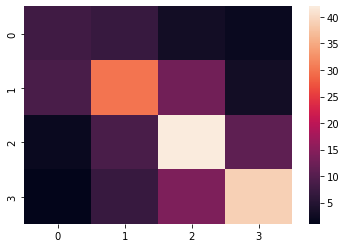

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [ ]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [ ]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [ ]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [ ]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [ ]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


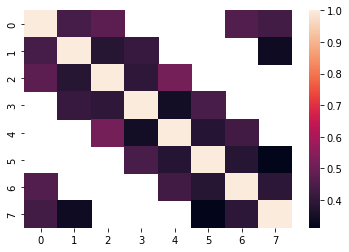

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

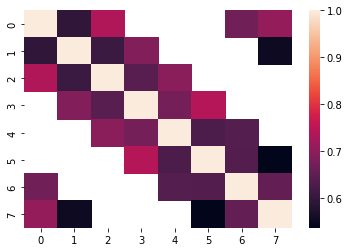

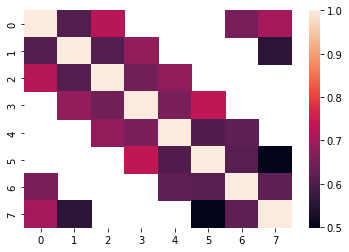

In [ ]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [ ]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/39937/files/6674661?wrap=1), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [ ]:
#I'm not sure how to import my data from the survey so I'm going to create an numpy array to translate relevant observations
#fielded a survey to three of my friends in which they classify the sentiments of pieces of text
y = np.array([[2,2,2,7,9,5,2,1,1,8],[1,1,3,6,9,7,4,2,1,8],[1,3,3,6,8,6,4,2,1,6]])
print(y)
anno = AnnotationsContainer.from_array(y, missing_values=[-1])

[[2 2 2 7 9 5 2 1 1 8]
 [1 1 3 6 9 7 4 2 1 8]
 [1 3 3 6 8 6 4 2 1 6]]


In [ ]:
anno.annotations

array([[1, 1, 1, 6, 8, 4, 1, 0, 0, 7],
       [0, 0, 2, 5, 8, 6, 3, 1, 0, 7],
       [0, 2, 2, 5, 7, 5, 3, 1, 0, 5]])

In [ ]:
anno.labels

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
anno.missing_values

[]

In [ ]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.23333333, 0.2       , 0.1       , 0.06666667, 0.03333333,
       0.13333333, 0.06666667, 0.1       , 0.06666667])

[[1. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


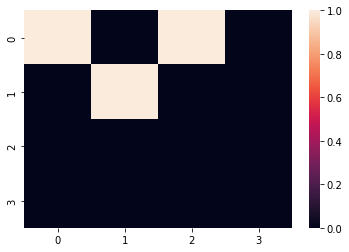

In [ ]:
#create confusion matrix
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [ ]:
#Scott's pi:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4545454545454544

In [ ]:
#Fleiss Kappa
fleiss_kappa(anno.annotations[::])

-0.04166666666666671

In [ ]:
#Krippendorff's alpha
krippendorffs_alpha(anno.annotations[::])

-0.07182604940117265

In [ ]:
#Cohen's kappa
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.49999999999999994

In [ ]:
#pairwise matrix
matrix = pairwise_matrix(cohens_kappa, anno.annotations)
print(matrix)

[[ 1.          0.5         0.25        0.          0.          0.
   0.25       -0.8         0.          0.        ]
 [ 0.5         1.          0.5         0.          0.          0.
   0.25       -0.5         0.          0.        ]
 [ 0.25        0.5         1.          0.          0.          0.
   0.25       -0.28571429  0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.14285714]
 [ 0.          0.          0.          0.          1.          0.
   0.          0.          0.         -0.28571429]
 [ 0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.25      ]
 [ 0.25        0.25        0.25        0.          0.          0.
   1.         -0.28571429  0.          0.        ]
 [-0.8        -0.5        -0.28571429  0.          0.          0.
  -0.28571429  1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0

/usr/local/lib/python3.7/dist-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


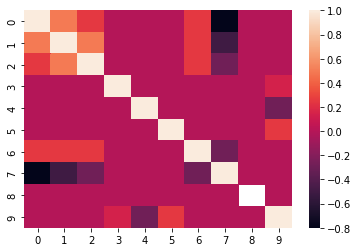

In [ ]:
#create heatmap
ax = seaborn.heatmap(matrix)
plt.show()

In [ ]:
#assess average cohen's kappa for all pairs of coders
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    matrix = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in matrix if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)  
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.0052380952380952405

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.25

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

-8.658008658008167e-05

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


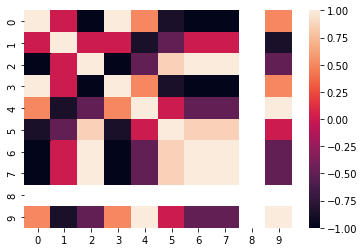

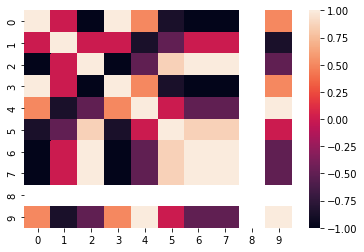

In [ ]:
n_1 = pairwise_matrix(pearsons_rho, anno.annotations)
m_1 = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n_1)
plt.show()
am = seaborn.heatmap(m_1)
plt.show()

In [ ]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

-0.09350070566067886 -0.09350070566067886


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


As far as I understand, the coders I sent my survey to seem to largely agree about the sentiments of the pieces of text I let them analyze. I wonder how different this would be if the sample size was increased to n = 10, n = 100, or n = 1000. I do find it interesting how precisely we can measure this coder-reliability, and how different ways of measurement provide such different results.

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [ ]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [ ]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [ ]:
dfTrain

,vect,category
186,"[0.04665713697496365, -1.2461117645928423]",0
498,"[0.09544825260668494, -0.7496953510113735]",0
15,"[-0.9249882223190848, -1.165475367168911]",1
251,"[-0.4105524103655833, -0.22005971612271266]",1
745,"[-0.7719559918494397, -0.6343735623263982]",1
...,...,...
412,"[-0.8788733696010866, 0.1651498942261252]",0
214,"[-0.7032283337138213, 0.10125509319852048]",0
351,"[-0.7914983400647522, -0.37245141174351076]",1
690,"[-0.6640322855724918, 0.44484017841175144]",0


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [ ]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


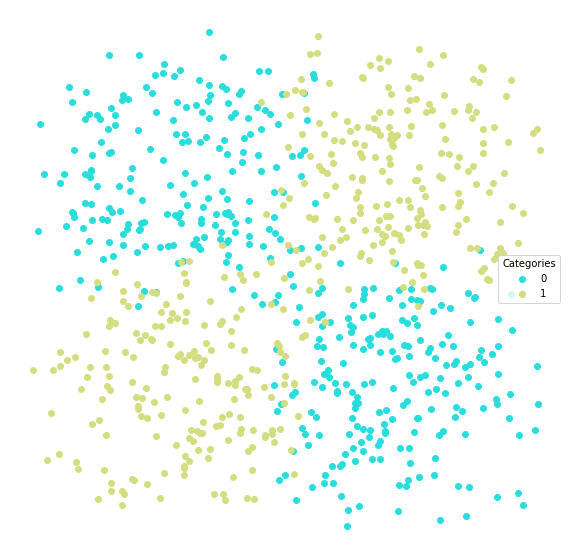

In [ ]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf = sklearn.svm.SVC(kernel = 'linear', probability = False) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [ ]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'random',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

SVC(kernel='linear')

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [ ]:
dfTrain['vect']

186        [0.04665713697496365, -1.2461117645928423]
498        [0.09544825260668494, -0.7496953510113735]
15          [-0.9249882223190848, -1.165475367168911]
251       [-0.4105524103655833, -0.22005971612271266]
745        [-0.7719559918494397, -0.6343735623263982]
                            ...                      
412         [-0.8788733696010866, 0.1651498942261252]
214        [-0.7032283337138213, 0.10125509319852048]
351       [-0.7914983400647522, -0.37245141174351076]
690        [-0.6640322855724918, 0.44484017841175144]
49     [0.0022102161553501642, -0.058641779629538204]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [ ]:
np.stack(dfTrain['vect'])

array([[ 0.04665714, -1.24611176],
       [ 0.09544825, -0.74969535],
       [-0.92498822, -1.16547537],
       ...,
       [-0.79149834, -0.37245141],
       [-0.66403229,  0.44484018],
       [ 0.00221022, -0.05864178]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.395,0.612001,0.561644,0.549792,0.845361
1,0.395,0.612001,0.722222,0.593463,0.378641


This lets us look at which classes do better:

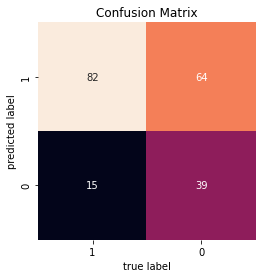

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

The <class 'sklearn.svm._classes.SVC'> classifier does not apear to support prediction probabilties, so an ROC curve can't be created. You can try adding `probability = True` to the model specification or use a different model.


We can also look at the regions the classifer identifies as one class or the other:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


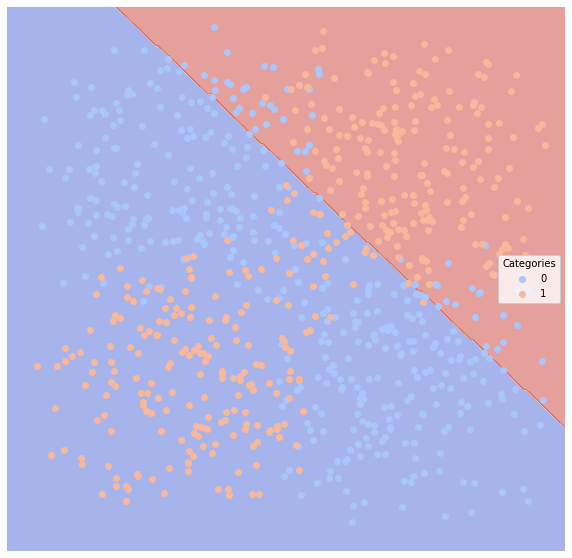

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [ ]:
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

In [ ]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.425,0.579271,0.546875,0.529652,0.721649
1,0.425,0.579271,0.625000,0.563058,0.436893


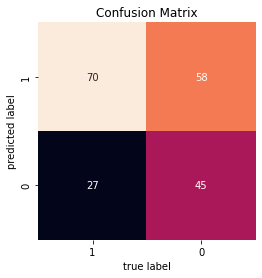

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

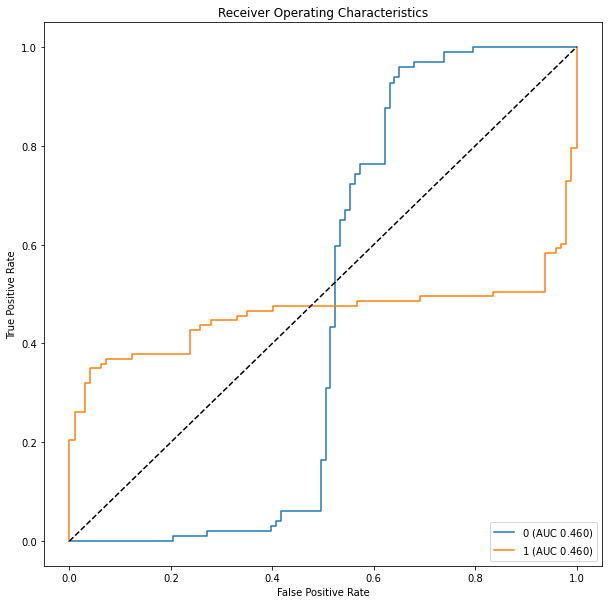

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


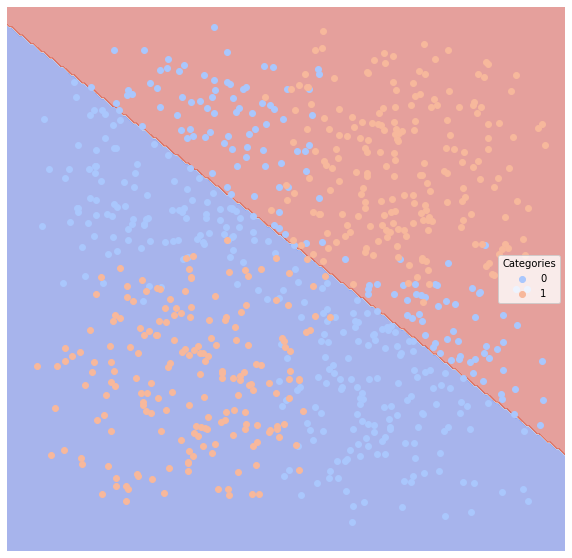

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [ ]:
#generate data:
#identifying different noises to generate new data
noise1 = .3
noise2 = .7
noise3 = .99

dfTrain1, dfTest1 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise1), test_size=.2)
dfTrain2, dfTest2 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise2), test_size=.2)
dfTrain3, dfTest3 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise3), test_size=.2)
dfTrain4, dfTest4 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise1), test_size=.2)
dfTrain5, dfTest5 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise2), test_size=.2)
dfTrain6, dfTest6 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise3), test_size=.2)
dfTrain7, dfTest7 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise1), test_size=.2)
dfTrain8, dfTest8 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise2), test_size=.2)
dfTrain9, dfTest9 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise3), test_size=.2)
dfTrain10, dfTest10 = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise1), test_size=.2)

In [ ]:
#train the algorithm
#Analogizes
clf1 = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf2 = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf3 = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf4 = sklearn.linear_model.LogisticRegression()

#Symbolists
clf5 = sklearn.tree.DecisionTreeClassifier()
clf6 = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf7 = sklearn.neural_network.MLPClassifier()

#Ensemble
clf8 = sklearn.ensemble.GradientBoostingClassifier()
clf9 = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
#loop over classifiers
classifiers = {}

for i in range(1,11):
    trainingData = locals()[f'dfTrain{i}']
    testData = locals()[f'dfTest{i}']
    for j in range(1,10):
        classifiers[f'classifier{j}data{i}'] = locals()[f'clf{j}']
        classifiers[f'classifier{j}data{i}'].fit(np.stack(trainingData['vect'], axis=0), trainingData['category'])
        print('')
        print(f'running classifier{j}data{i}')
        print(lucem_illud.evaluateClassifier(locals()[f'clf{j}'], dfTest))

SyntaxError: ignored

#Interpretation
For dataset 1, classifier 6 works best;
For dataset 2, classifier 2 works best;
For dataset 3, classifier 2 works best;
For dataset 4, classifier 7 works best;
For dataset 5, classifier 7 works best;
For dataset 6, classifier 5 works best;
For dataset 7, classifier 4 works best;
For dataset 8, classifier 5 works best;
For dataset 9, classifier 2 works best;
For dataset 10, a lot of classifiers performed at very similar levels.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [ ]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

FileNotFoundError: ignored

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [ ]:
type(ObamaClintonReleases)

It's a DataFrame! and it looks like this:

In [ ]:
ObamaClintonReleases

Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [ ]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [ ]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [ ]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [ ]:
print(len(train_data_df))
print(len(test_data_df))

## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [ ]:
TFVects.shape

We can save this in the dataframe to make things easier

In [ ]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [ ]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

In [ ]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [ ]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [ ]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [ ]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

Slightly poorer. How about using more dimensions (40)?

In [ ]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Or still more (100)?

In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Or even more (200)!

In [ ]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

This is becoming ridiculous (400)!

In [ ]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [ ]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

Train the model using training data, and then test it on the testing data.

In [ ]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [4]:
#import data
import os
import pandas as pd
import zipfile
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
def loadcorpus(targetdir,endpoint=False):
    break_flag = False
    texts = pd.DataFrame()
    for file1 in os.listdir(targetdir):
        file1name = os.fsdecode(file1)
        if file1name.startswith('text'):
            zfile = zipfile.ZipFile(targetdir + '/' + file1)
            for file2 in zfile.namelist():
                file2name = os.fsdecode(file2)
                #optional endpoint if you only want a portion of the NOW corpus
                if file2name == endpoint:
                    break_flag = True
                    break
                print(file2name)
                data = pd.read_fwf(zfile.open(f'{file2name}'),colspecs=[(2,10),(11,None)],encoding='utf-8',names=['id','body'])
                texts = texts.append(data,ignore_index=True)
        if break_flag == True:
            break
    return texts

In [ ]:
texts = loadcorpus('/content/drive/MyDrive/NOW','18-04-au.txt')

10-01-au.txt
10-01-bd.txt
10-01-ca.txt
10-01-gb.txt
10-01-gh.txt
10-01-hk.txt
10-01-ie.txt
10-01-in.txt
10-01-jm.txt
10-01-ke.txt
10-01-lk.txt
10-01-my.txt
10-01-ng.txt
10-01-nz.txt
10-01-ph.txt
10-01-pk.txt
10-01-sg.txt
10-01-tz.txt
10-01-us.txt
10-01-za.txt
10-02-au.txt
10-02-bd.txt
10-02-ca.txt
10-02-gb.txt
10-02-gh.txt
10-02-hk.txt
10-02-ie.txt
10-02-in.txt
10-02-jm.txt
10-02-ke.txt
10-02-lk.txt
10-02-my.txt
10-02-ng.txt
10-02-nz.txt
10-02-ph.txt
10-02-pk.txt
10-02-sg.txt
10-02-tz.txt
10-02-us.txt
10-02-za.txt
10-03-au.txt
10-03-bd.txt
10-03-ca.txt
10-03-gb.txt
10-03-gh.txt
10-03-hk.txt
10-03-ie.txt
10-03-in.txt
10-03-jm.txt
10-03-ke.txt
10-03-lk.txt
10-03-my.txt
10-03-ng.txt
10-03-nz.txt
10-03-ph.txt
10-03-pk.txt
10-03-sg.txt
10-03-tz.txt
10-03-us.txt
10-03-za.txt
10-04-au.txt
10-04-bd.txt
10-04-ca.txt
10-04-gb.txt
10-04-gh.txt
10-04-hk.txt
10-04-ie.txt
10-04-in.txt
10-04-jm.txt
10-04-ke.txt
10-04-lk.txt
10-04-my.txt
10-04-ng.txt
10-04-nz.txt
10-04-ph.txt
10-04-pk.txt
10-04-sg.txt

In [2]:
texts

NameError: ignored

In [ ]:
def loadmetadata(targetdir):
    metadata = pd.DataFrame()
    for file1 in os.listdir(targetdir):
        file1name = os.fsdecode(file1)
        print(file1name)
        if file1name.startswith('now_sources') or file1name.startswith('sources'):
            zfile = zipfile.ZipFile(targetdir + '/' + file1)
            for file2 in zfile.namelist():
                file2name = os.fsdecode(file2)
                print(file2name)
                data = pd.read_csv(zfile.open(f'{file2name}'),sep='\t',error_bad_lines=False,engine='python',encoding='latin1',names=['id','length','date','country','publisher','url','snippet'])
                metadata = metadata.append(data,ignore_index=True)
    return metadata

In [ ]:
metadata = loadmetadata('/content/drive/MyDrive/NOW')

text_10-01-kus.zip
text_10-02-kvz.zip
text_10-03-ovi.zip
text_10-04-laq.zip
text_10-05-wbb.zip
text_10-06-bwq.zip
text_10-07-uek.zip
text_10-08-lqd.zip
text_10-09-udn.zip
text_10-10-nln.zip
text_10-11-weq.zip
text_10-12-ixv.zip
text_11-01-pct.zip
text_11-02-keb.zip
text_11-03-lup.zip
text_11-04-fpt.zip
text_11-05-gbc.zip
text_11-06-hld.zip
text_11-07-mpk.zip
text_11-08-lag.zip
text_11-09-ptj.zip
text_11-10-qsy.zip
text_11-11-rst.zip
text_11-12-dxg.zip
text_12-01-jgs.zip
text_12-02-eig.zip
text_12-03-hge.zip
text_12-04-qzl.zip
text_12-05-qvg.zip
text_12-06-ury.zip
text_12-07-jbh.zip
text_12-08-apx.zip
text_12-09-qxc.zip
text_12-10-fim.zip
text_12-11-ysq.zip
text_12-12-fbe.zip
text_13-01-lii.zip
text_13-02-fwy.zip
text_13-03-zxv.zip
text_13-04-vzr.zip
text_13-05-skm.zip
text_13-06-rak.zip
text_13-07-mht.zip
text_13-08-ofo.zip
text_13-09-ibd.zip
text_13-10-zpv.zip
text_13-11-vwg.zip
text_13-12-yny.zip
text_14-01-jhx.zip
text_14-02-fbh.zip
text_14-03-mps.zip
text_14-04-oki.zip
text_14-05-c

Skipping line 427: '	' expected after '"'
Skipping line 669: '	' expected after '"'
Skipping line 725: '	' expected after '"'
Skipping line 837: '	' expected after '"'
Skipping line 878: '	' expected after '"'
Skipping line 1073: '	' expected after '"'
Skipping line 1218: '	' expected after '"'
Skipping line 1364: '	' expected after '"'
Skipping line 1845: '	' expected after '"'
Skipping line 1864: '	' expected after '"'
Skipping line 2506: '	' expected after '"'
Skipping line 3416: '	' expected after '"'
Skipping line 3444: '	' expected after '"'
Skipping line 3504: '	' expected after '"'
Skipping line 3599: '	' expected after '"'
Skipping line 4145: '	' expected after '"'
Skipping line 4333: '	' expected after '"'
Skipping line 4418: '	' expected after '"'
Skipping line 4436: '	' expected after '"'
Skipping line 4452: '	' expected after '"'
Skipping line 4987: '	' expected after '"'
Skipping line 5411: '	' expected after '"'
Skipping line 5669: '	' expected after '"'
Skipping line 58

text-16-12.zip
sources-16-12.zip
sources-16-12.txt


Skipping line 250: '	' expected after '"'
Skipping line 315: '	' expected after '"'
Skipping line 928: '	' expected after '"'
Skipping line 1581: '	' expected after '"'
Skipping line 2295: '	' expected after '"'
Skipping line 2864: '	' expected after '"'
Skipping line 3395: '	' expected after '"'
Skipping line 4285: '	' expected after '"'
Skipping line 4947: '	' expected after '"'
Skipping line 6159: '	' expected after '"'
Skipping line 7070: '	' expected after '"'
Skipping line 7345: '	' expected after '"'
Skipping line 8224: '	' expected after '"'
Skipping line 8241: '	' expected after '"'
Skipping line 8612: '	' expected after '"'
Skipping line 8656: '	' expected after '"'
Skipping line 8814: '	' expected after '"'
Skipping line 8948: '	' expected after '"'
Skipping line 9188: '	' expected after '"'
Skipping line 9446: '	' expected after '"'
Skipping line 9491: '	' expected after '"'
Skipping line 9809: '	' expected after '"'
Skipping line 10017: '	' expected after '"'
Skipping line

sources-17-01.zip
sources-17-01.txt


Skipping line 118: '	' expected after '"'
Skipping line 948: '	' expected after '"'
Skipping line 1069: '	' expected after '"'
Skipping line 1421: '	' expected after '"'
Skipping line 1665: '	' expected after '"'
Skipping line 2041: '	' expected after '"'
Skipping line 2244: '	' expected after '"'
Skipping line 2358: '	' expected after '"'
Skipping line 3333: '	' expected after '"'
Skipping line 4050: '	' expected after '"'
Skipping line 4143: '	' expected after '"'
Skipping line 4885: '	' expected after '"'
Skipping line 5842: '	' expected after '"'
Skipping line 6717: '	' expected after '"'
Skipping line 7161: '	' expected after '"'
Skipping line 7355: '	' expected after '"'
Skipping line 7459: '	' expected after '"'
Skipping line 7665: '	' expected after '"'
Skipping line 9274: '	' expected after '"'
Skipping line 9356: '	' expected after '"'
Skipping line 9638: '	' expected after '"'
Skipping line 10324: '	' expected after '"'
Skipping line 10879: '	' expected after '"'
Skipping li

text-17-01.zip
text-17-02.zip
sources-17-02.zip
sources-17-02.txt


Skipping line 517: '	' expected after '"'
Skipping line 655: '	' expected after '"'
Skipping line 843: '	' expected after '"'
Skipping line 1443: '	' expected after '"'
Skipping line 1712: '	' expected after '"'
Skipping line 2581: '	' expected after '"'
Skipping line 2808: '	' expected after '"'
Skipping line 3748: '	' expected after '"'
Skipping line 3864: '	' expected after '"'
Skipping line 4842: '	' expected after '"'
Skipping line 6858: '	' expected after '"'
Skipping line 6867: '	' expected after '"'
Skipping line 7237: '	' expected after '"'
Skipping line 7464: '	' expected after '"'
Skipping line 7657: '	' expected after '"'
Skipping line 7674: '	' expected after '"'
Skipping line 7715: '	' expected after '"'
Skipping line 7926: '	' expected after '"'
Skipping line 7957: '	' expected after '"'
Skipping line 8002: '	' expected after '"'
Skipping line 8216: '	' expected after '"'
Skipping line 8630: '	' expected after '"'
Skipping line 8982: '	' expected after '"'
Skipping line 

text-17-03.zip
sources-17-03.zip
sources-17-03.txt


Skipping line 67: '	' expected after '"'
Skipping line 815: '	' expected after '"'
Skipping line 867: '	' expected after '"'
Skipping line 1139: '	' expected after '"'
Skipping line 1246: '	' expected after '"'
Skipping line 1271: '	' expected after '"'
Skipping line 2004: '	' expected after '"'
Skipping line 2828: '	' expected after '"'
Skipping line 3724: '	' expected after '"'
Skipping line 4161: '	' expected after '"'
Skipping line 4183: '	' expected after '"'
Skipping line 4184: '	' expected after '"'
Skipping line 5600: '	' expected after '"'
Skipping line 6349: '	' expected after '"'
Skipping line 6422: '	' expected after '"'
Skipping line 6763: '	' expected after '"'
Skipping line 6842: '	' expected after '"'
Skipping line 7569: '	' expected after '"'
Skipping line 7649: '	' expected after '"'
Skipping line 8176: '	' expected after '"'
Skipping line 11067: '	' expected after '"'
Skipping line 11084: '	' expected after '"'
Skipping line 12006: '	' expected after '"'
Skipping lin

text-17-04.zip
sources-17-04.zip
sources-17-04.txt


Skipping line 448: '	' expected after '"'
Skipping line 735: '	' expected after '"'
Skipping line 1122: '	' expected after '"'
Skipping line 1307: '	' expected after '"'
Skipping line 1449: '	' expected after '"'
Skipping line 1496: '	' expected after '"'
Skipping line 1572: '	' expected after '"'
Skipping line 1948: '	' expected after '"'
Skipping line 2838: '	' expected after '"'
Skipping line 2993: '	' expected after '"'
Skipping line 3641: '	' expected after '"'
Skipping line 3730: '	' expected after '"'
Skipping line 3857: '	' expected after '"'
Skipping line 3924: '	' expected after '"'
Skipping line 4145: '	' expected after '"'
Skipping line 4644: '	' expected after '"'
Skipping line 4662: '	' expected after '"'
Skipping line 4859: '	' expected after '"'
Skipping line 5073: '	' expected after '"'
Skipping line 5201: '	' expected after '"'
Skipping line 5236: '	' expected after '"'
Skipping line 5303: '	' expected after '"'
Skipping line 5377: '	' expected after '"'
Skipping line

text-17-05.zip
sources-17-05.zip
sources-17-05.txt


Skipping line 482: '	' expected after '"'
Skipping line 506: '	' expected after '"'
Skipping line 775: '	' expected after '"'
Skipping line 855: '	' expected after '"'
Skipping line 916: '	' expected after '"'
Skipping line 1132: '	' expected after '"'
Skipping line 1202: '	' expected after '"'
Skipping line 1659: '	' expected after '"'
Skipping line 2004: '	' expected after '"'
Skipping line 2149: '	' expected after '"'
Skipping line 2331: '	' expected after '"'
Skipping line 2672: '	' expected after '"'
Skipping line 3296: '	' expected after '"'
Skipping line 3351: '	' expected after '"'
Skipping line 3379: '	' expected after '"'
Skipping line 3765: '	' expected after '"'
Skipping line 3816: '	' expected after '"'
Skipping line 4198: '	' expected after '"'
Skipping line 4536: '	' expected after '"'
Skipping line 4656: '	' expected after '"'
Skipping line 5175: '	' expected after '"'
Skipping line 5555: '	' expected after '"'
Skipping line 5955: '	' expected after '"'
Skipping line 60

text-17-06.zip
sources-17-06.zip
sources-17-06.txt


Skipping line 94: '	' expected after '"'
Skipping line 158: '	' expected after '"'
Skipping line 166: '	' expected after '"'
Skipping line 714: '	' expected after '"'
Skipping line 721: '	' expected after '"'
Skipping line 2061: '	' expected after '"'
Skipping line 2341: '	' expected after '"'
Skipping line 2531: '	' expected after '"'
Skipping line 2845: '	' expected after '"'
Skipping line 2932: '	' expected after '"'
Skipping line 2992: '	' expected after '"'
Skipping line 3246: '	' expected after '"'
Skipping line 4074: '	' expected after '"'
Skipping line 4882: '	' expected after '"'
Skipping line 4976: '	' expected after '"'
Skipping line 5288: '	' expected after '"'
Skipping line 5350: '	' expected after '"'
Skipping line 5407: '	' expected after '"'
Skipping line 6186: '	' expected after '"'
Skipping line 6234: '	' expected after '"'
Skipping line 6266: '	' expected after '"'
Skipping line 7342: '	' expected after '"'
Skipping line 7790: '	' expected after '"'
Skipping line 819

text-17-07.zip
sources-17-07.zip
sources-17-07.txt


Skipping line 103: '	' expected after '"'
Skipping line 174: '	' expected after '"'
Skipping line 1046: '	' expected after '"'
Skipping line 1411: '	' expected after '"'
Skipping line 2036: '	' expected after '"'
Skipping line 2723: '	' expected after '"'
Skipping line 3245: '	' expected after '"'
Skipping line 3343: '	' expected after '"'
Skipping line 4588: '	' expected after '"'
Skipping line 6065: '	' expected after '"'
Skipping line 6108: '	' expected after '"'
Skipping line 6541: '	' expected after '"'
Skipping line 7116: '	' expected after '"'
Skipping line 7627: '	' expected after '"'
Skipping line 8319: '	' expected after '"'
Skipping line 8641: '	' expected after '"'
Skipping line 8690: '	' expected after '"'
Skipping line 10053: '	' expected after '"'
Skipping line 10062: '	' expected after '"'
Skipping line 10065: '	' expected after '"'
Skipping line 10186: '	' expected after '"'
Skipping line 10737: '	' expected after '"'
Skipping line 10792: '	' expected after '"'
Skippin

text-17-08.zip
sources-17-08.zip
sources-17-08.txt


Skipping line 437: '	' expected after '"'
Skipping line 510: '	' expected after '"'
Skipping line 690: '	' expected after '"'
Skipping line 2331: '	' expected after '"'
Skipping line 2769: '	' expected after '"'
Skipping line 3160: '	' expected after '"'
Skipping line 3469: '	' expected after '"'
Skipping line 3615: '	' expected after '"'
Skipping line 4595: '	' expected after '"'
Skipping line 4613: '	' expected after '"'
Skipping line 4883: '	' expected after '"'
Skipping line 5106: '	' expected after '"'
Skipping line 5561: '	' expected after '"'
Skipping line 5736: '	' expected after '"'
Skipping line 5841: '	' expected after '"'
Skipping line 6812: '	' expected after '"'
Skipping line 7295: '	' expected after '"'
Skipping line 7352: '	' expected after '"'
Skipping line 7468: '	' expected after '"'
Skipping line 7641: '	' expected after '"'
Skipping line 7682: '	' expected after '"'
Skipping line 9409: '	' expected after '"'
Skipping line 9870: '	' expected after '"'
Skipping line 

text-17-09.zip
sources-17-09.zip
sources-17-09.txt


Skipping line 81: '	' expected after '"'
Skipping line 213: '	' expected after '"'
Skipping line 2422: '	' expected after '"'
Skipping line 2841: '	' expected after '"'
Skipping line 3308: '	' expected after '"'
Skipping line 3327: '	' expected after '"'
Skipping line 4922: '	' expected after '"'
Skipping line 4933: '	' expected after '"'
Skipping line 5519: '	' expected after '"'
Skipping line 5796: '	' expected after '"'
Skipping line 5813: '	' expected after '"'
Skipping line 6930: '	' expected after '"'
Skipping line 7190: '	' expected after '"'
Skipping line 7273: '	' expected after '"'
Skipping line 7354: '	' expected after '"'
Skipping line 7422: '	' expected after '"'
Skipping line 7531: '	' expected after '"'
Skipping line 8041: '	' expected after '"'
Skipping line 8542: '	' expected after '"'
Skipping line 9558: '	' expected after '"'
Skipping line 10630: '	' expected after '"'
Skipping line 11754: '	' expected after '"'
Skipping line 12254: '	' expected after '"'
Skipping li

text-17-10.zip
sources-17-10.zip
sources-17-10.txt


Skipping line 1157: '	' expected after '"'
Skipping line 1182: '	' expected after '"'
Skipping line 1224: '	' expected after '"'
Skipping line 1549: '	' expected after '"'
Skipping line 1683: '	' expected after '"'
Skipping line 1860: '	' expected after '"'
Skipping line 2371: '	' expected after '"'
Skipping line 2704: '	' expected after '"'
Skipping line 2975: '	' expected after '"'
Skipping line 3516: '	' expected after '"'
Skipping line 4122: '	' expected after '"'
Skipping line 4376: '	' expected after '"'
Skipping line 4833: '	' expected after '"'
Skipping line 4943: '	' expected after '"'
Skipping line 5702: '	' expected after '"'
Skipping line 7266: '	' expected after '"'
Skipping line 8137: '	' expected after '"'
Skipping line 8209: '	' expected after '"'
Skipping line 8246: '	' expected after '"'
Skipping line 8331: '	' expected after '"'
Skipping line 8529: '	' expected after '"'
Skipping line 9175: '	' expected after '"'
Skipping line 9230: '	' expected after '"'
Skipping li

sources-17-11.zip
sources-17-11.txt


Skipping line 101: '	' expected after '"'
Skipping line 527: '	' expected after '"'
Skipping line 1367: '	' expected after '"'
Skipping line 1809: '	' expected after '"'
Skipping line 2682: '	' expected after '"'
Skipping line 4040: '	' expected after '"'
Skipping line 4114: '	' expected after '"'
Skipping line 4653: '	' expected after '"'
Skipping line 4790: '	' expected after '"'
Skipping line 5043: '	' expected after '"'
Skipping line 5160: '	' expected after '"'
Skipping line 5268: '	' expected after '"'
Skipping line 5884: '	' expected after '"'
Skipping line 6185: '	' expected after '"'
Skipping line 6452: '	' expected after '"'
Skipping line 6552: '	' expected after '"'
Skipping line 6576: '	' expected after '"'
Skipping line 6806: '	' expected after '"'
Skipping line 6990: '	' expected after '"'
Skipping line 7218: '	' expected after '"'
Skipping line 7316: '	' expected after '"'
Skipping line 7486: '	' expected after '"'
Skipping line 7904: '	' expected after '"'
Skipping line

text-17-11.zip
text-17-12.zip
sources-17-12.zip
sources-17-12.txt


Skipping line 155: '	' expected after '"'
Skipping line 170: '	' expected after '"'
Skipping line 1089: '	' expected after '"'
Skipping line 1422: '	' expected after '"'
Skipping line 1694: '	' expected after '"'
Skipping line 2087: '	' expected after '"'
Skipping line 2350: '	' expected after '"'
Skipping line 2956: '	' expected after '"'
Skipping line 2982: '	' expected after '"'
Skipping line 3007: '	' expected after '"'
Skipping line 4470: '	' expected after '"'
Skipping line 4725: '	' expected after '"'
Skipping line 4998: '	' expected after '"'
Skipping line 5589: '	' expected after '"'
Skipping line 5664: '	' expected after '"'
Skipping line 7190: '	' expected after '"'
Skipping line 7332: '	' expected after '"'
Skipping line 7462: '	' expected after '"'
Skipping line 8994: '	' expected after '"'
Skipping line 9131: '	' expected after '"'
Skipping line 9866: '	' expected after '"'
Skipping line 11453: '	' expected after '"'
Skipping line 11559: '	' expected after '"'
Skipping li

text-18-01.zip
sources-18-01.zip
sources-18-01.txt


Skipping line 393: '	' expected after '"'
Skipping line 571: '	' expected after '"'
Skipping line 665: '	' expected after '"'
Skipping line 737: '	' expected after '"'
Skipping line 804: '	' expected after '"'
Skipping line 1794: '	' expected after '"'
Skipping line 2012: '	' expected after '"'
Skipping line 2794: '	' expected after '"'
Skipping line 3337: '	' expected after '"'
Skipping line 3358: '	' expected after '"'
Skipping line 3843: '	' expected after '"'
Skipping line 4814: '	' expected after '"'
Skipping line 5090: '	' expected after '"'
Skipping line 5155: '	' expected after '"'
Skipping line 5302: '	' expected after '"'
Skipping line 5885: '	' expected after '"'
Skipping line 5982: '	' expected after '"'
Skipping line 6272: '	' expected after '"'
Skipping line 6750: '	' expected after '"'
Skipping line 6873: '	' expected after '"'
Skipping line 6901: '	' expected after '"'
Skipping line 7264: '	' expected after '"'
Skipping line 7758: '	' expected after '"'
Skipping line 80

text-18-02.zip
sources-18-02.zip
sources-18-02.txt


Skipping line 32: '	' expected after '"'
Skipping line 1316: '	' expected after '"'
Skipping line 1830: '	' expected after '"'
Skipping line 1923: '	' expected after '"'
Skipping line 4397: '	' expected after '"'
Skipping line 4659: '	' expected after '"'
Skipping line 4941: '	' expected after '"'
Skipping line 5268: '	' expected after '"'
Skipping line 5535: '	' expected after '"'
Skipping line 6198: '	' expected after '"'
Skipping line 6238: '	' expected after '"'
Skipping line 6285: '	' expected after '"'
Skipping line 6348: '	' expected after '"'
Skipping line 6397: '	' expected after '"'
Skipping line 6541: '	' expected after '"'
Skipping line 7550: '	' expected after '"'
Skipping line 7938: '	' expected after '"'
Skipping line 8597: '	' expected after '"'
Skipping line 9924: '	' expected after '"'
Skipping line 10093: '	' expected after '"'
Skipping line 10465: '	' expected after '"'
Skipping line 11210: '	' expected after '"'
Skipping line 11733: '	' expected after '"'
Skipping 

text-18-03.zip
sources-18-03.zip
sources-18-03.txt


Skipping line 304: '	' expected after '"'
Skipping line 935: '	' expected after '"'
Skipping line 944: '	' expected after '"'
Skipping line 1039: '	' expected after '"'
Skipping line 1196: '	' expected after '"'
Skipping line 1597: '	' expected after '"'
Skipping line 2023: '	' expected after '"'
Skipping line 2971: '	' expected after '"'
Skipping line 4034: '	' expected after '"'
Skipping line 4113: '	' expected after '"'
Skipping line 5650: '	' expected after '"'
Skipping line 5730: '	' expected after '"'
Skipping line 5769: '	' expected after '"'
Skipping line 6122: '	' expected after '"'
Skipping line 6161: '	' expected after '"'
Skipping line 6833: '	' expected after '"'
Skipping line 7132: '	' expected after '"'
Skipping line 7197: '	' expected after '"'
Skipping line 7468: '	' expected after '"'
Skipping line 7567: '	' expected after '"'
Skipping line 7929: '	' expected after '"'
Skipping line 8762: '	' expected after '"'
Skipping line 9124: '	' expected after '"'
Skipping line 

text-18-04.zip
sources-18-04.zip
sources-18-04.txt


Skipping line 693: '	' expected after '"'
Skipping line 894: '	' expected after '"'
Skipping line 1051: '	' expected after '"'
Skipping line 1803: '	' expected after '"'
Skipping line 2701: '	' expected after '"'
Skipping line 2755: '	' expected after '"'
Skipping line 2798: '	' expected after '"'
Skipping line 2995: '	' expected after '"'
Skipping line 4609: '	' expected after '"'
Skipping line 4765: '	' expected after '"'
Skipping line 4841: '	' expected after '"'
Skipping line 5525: '	' expected after '"'
Skipping line 6171: '	' expected after '"'
Skipping line 6246: '	' expected after '"'
Skipping line 6537: '	' expected after '"'
Skipping line 6916: '	' expected after '"'
Skipping line 7794: '	' expected after '"'
Skipping line 8239: '	' expected after '"'
Skipping line 8410: '	' expected after '"'
Skipping line 9034: '	' expected after '"'
Skipping line 9985: '	' expected after '"'
Skipping line 10103: '	' expected after '"'
Skipping line 11558: '	' expected after '"'
Skipping li

text-18-05.zip
sources-18-05.zip
sources-18-05.txt


Skipping line 917: '	' expected after '"'
Skipping line 2149: '	' expected after '"'
Skipping line 2165: '	' expected after '"'
Skipping line 3642: '	' expected after '"'
Skipping line 4324: '	' expected after '"'
Skipping line 4692: '	' expected after '"'
Skipping line 5469: '	' expected after '"'
Skipping line 5749: '	' expected after '"'
Skipping line 6311: '	' expected after '"'
Skipping line 6385: '	' expected after '"'
Skipping line 6794: '	' expected after '"'
Skipping line 6855: '	' expected after '"'
Skipping line 7162: '	' expected after '"'
Skipping line 7516: '	' expected after '"'
Skipping line 8183: '	' expected after '"'
Skipping line 8286: '	' expected after '"'
Skipping line 8808: '	' expected after '"'
Skipping line 10540: '	' expected after '"'
Skipping line 10629: '	' expected after '"'
Skipping line 10729: '	' expected after '"'
Skipping line 11410: '	' expected after '"'
Skipping line 11601: '	' expected after '"'
Skipping line 11660: '	' expected after '"'
Skippi

text-18-06.zip
sources-18-06.zip
sources-18-06.txt


Skipping line 196: '	' expected after '"'
Skipping line 531: '	' expected after '"'
Skipping line 1225: '	' expected after '"'
Skipping line 1422: '	' expected after '"'
Skipping line 1536: '	' expected after '"'
Skipping line 2414: '	' expected after '"'
Skipping line 3258: '	' expected after '"'
Skipping line 3611: '	' expected after '"'
Skipping line 3922: '	' expected after '"'
Skipping line 4791: '	' expected after '"'
Skipping line 5029: '	' expected after '"'
Skipping line 5405: '	' expected after '"'
Skipping line 5762: '	' expected after '"'
Skipping line 5866: '	' expected after '"'
Skipping line 5910: '	' expected after '"'
Skipping line 6257: '	' expected after '"'
Skipping line 6296: '	' expected after '"'
Skipping line 6316: '	' expected after '"'
Skipping line 6449: '	' expected after '"'
Skipping line 6525: '	' expected after '"'
Skipping line 6533: '	' expected after '"'
Skipping line 6989: '	' expected after '"'
Skipping line 7448: '	' expected after '"'
Skipping line

text-18-07.zip
sources-18-07.zip
sources-18-07.txt


Skipping line 609: '	' expected after '"'
Skipping line 793: '	' expected after '"'
Skipping line 1501: '	' expected after '"'
Skipping line 1507: '	' expected after '"'
Skipping line 2284: '	' expected after '"'
Skipping line 2631: '	' expected after '"'
Skipping line 2799: '	' expected after '"'
Skipping line 3859: '	' expected after '"'
Skipping line 4888: '	' expected after '"'
Skipping line 5327: '	' expected after '"'
Skipping line 5438: '	' expected after '"'
Skipping line 5610: '	' expected after '"'
Skipping line 5856: '	' expected after '"'
Skipping line 6161: '	' expected after '"'
Skipping line 6692: '	' expected after '"'
Skipping line 6735: '	' expected after '"'
Skipping line 6736: '	' expected after '"'
Skipping line 7089: '	' expected after '"'
Skipping line 8256: '	' expected after '"'
Skipping line 8359: '	' expected after '"'
Skipping line 8628: '	' expected after '"'
Skipping line 9143: '	' expected after '"'
Skipping line 9240: '	' expected after '"'
Skipping line

text-18-08.zip
sources-18-08.zip
sources-18-08.txt


Skipping line 569: '	' expected after '"'
Skipping line 2223: '	' expected after '"'
Skipping line 3757: '	' expected after '"'
Skipping line 3952: '	' expected after '"'
Skipping line 4812: '	' expected after '"'
Skipping line 6551: '	' expected after '"'
Skipping line 6652: '	' expected after '"'
Skipping line 6813: '	' expected after '"'
Skipping line 7476: '	' expected after '"'
Skipping line 8284: '	' expected after '"'
Skipping line 8624: '	' expected after '"'
Skipping line 10474: '	' expected after '"'
Skipping line 11000: '	' expected after '"'
Skipping line 11539: '	' expected after '"'
Skipping line 11890: '	' expected after '"'
Skipping line 12436: '	' expected after '"'
Skipping line 12569: '	' expected after '"'
Skipping line 12963: '	' expected after '"'
Skipping line 13125: '	' expected after '"'
Skipping line 14162: '	' expected after '"'
Skipping line 20427: '	' expected after '"'
Skipping line 20554: '	' expected after '"'
Skipping line 22068: '	' expected after '"'


text-18-09.zip
text-18-10.zip
sources-18-10.zip
sources-18-10.txt


Skipping line 529: '	' expected after '"'
Skipping line 857: '	' expected after '"'
Skipping line 1425: '	' expected after '"'
Skipping line 2819: '	' expected after '"'
Skipping line 3136: '	' expected after '"'
Skipping line 4129: '	' expected after '"'
Skipping line 4174: '	' expected after '"'
Skipping line 4412: '	' expected after '"'
Skipping line 4498: '	' expected after '"'
Skipping line 4644: '	' expected after '"'
Skipping line 4722: '	' expected after '"'
Skipping line 5447: '	' expected after '"'
Skipping line 5650: '	' expected after '"'
Skipping line 5760: '	' expected after '"'
Skipping line 6776: '	' expected after '"'
Skipping line 8148: '	' expected after '"'
Skipping line 8849: '	' expected after '"'
Skipping line 8868: '	' expected after '"'
Skipping line 9253: '	' expected after '"'
Skipping line 9702: '	' expected after '"'
Skipping line 9782: '	' expected after '"'
Skipping line 10137: '	' expected after '"'
Skipping line 10182: '	' expected after '"'
Skipping li

text-18-11.zip
sources-18-11.zip
sources-18-11.txt


Skipping line 200: '	' expected after '"'
Skipping line 274: '	' expected after '"'
Skipping line 282: '	' expected after '"'
Skipping line 324: '	' expected after '"'
Skipping line 545: '	' expected after '"'
Skipping line 923: '	' expected after '"'
Skipping line 984: '	' expected after '"'
Skipping line 1123: '	' expected after '"'
Skipping line 2067: '	' expected after '"'
Skipping line 2212: '	' expected after '"'
Skipping line 2355: '	' expected after '"'
Skipping line 3061: '	' expected after '"'
Skipping line 3483: '	' expected after '"'
Skipping line 3649: '	' expected after '"'
Skipping line 3707: '	' expected after '"'
Skipping line 4460: '	' expected after '"'
Skipping line 6285: '	' expected after '"'
Skipping line 6685: '	' expected after '"'
Skipping line 7047: '	' expected after '"'
Skipping line 8090: '	' expected after '"'
Skipping line 8742: '	' expected after '"'
Skipping line 9014: '	' expected after '"'
Skipping line 9015: '	' expected after '"'
Skipping line 9252

text-18-12.zip
sources-18-12.zip
sources-18-12.txt


Skipping line 1924: '	' expected after '"'
Skipping line 1938: '	' expected after '"'
Skipping line 2293: '	' expected after '"'
Skipping line 2458: '	' expected after '"'
Skipping line 2588: '	' expected after '"'
Skipping line 2790: '	' expected after '"'
Skipping line 3831: '	' expected after '"'
Skipping line 4015: '	' expected after '"'
Skipping line 4022: '	' expected after '"'
Skipping line 4078: '	' expected after '"'
Skipping line 4660: '	' expected after '"'
Skipping line 4694: '	' expected after '"'
Skipping line 5607: '	' expected after '"'
Skipping line 6707: '	' expected after '"'
Skipping line 6996: '	' expected after '"'
Skipping line 7154: '	' expected after '"'
Skipping line 7632: '	' expected after '"'
Skipping line 7794: '	' expected after '"'
Skipping line 8098: '	' expected after '"'
Skipping line 8100: '	' expected after '"'
Skipping line 8191: '	' expected after '"'
Skipping line 8299: '	' expected after '"'
Skipping line 8335: '	' expected after '"'
Skipping li

text-19-01.zip
sources-19-01.zip
sources-19-01.txt


Skipping line 310: '	' expected after '"'
Skipping line 575: '	' expected after '"'
Skipping line 723: '	' expected after '"'
Skipping line 932: '	' expected after '"'
Skipping line 1805: '	' expected after '"'
Skipping line 2099: '	' expected after '"'
Skipping line 2173: '	' expected after '"'
Skipping line 2697: '	' expected after '"'
Skipping line 2979: '	' expected after '"'
Skipping line 3776: '	' expected after '"'
Skipping line 3950: '	' expected after '"'
Skipping line 4968: '	' expected after '"'
Skipping line 4972: '	' expected after '"'
Skipping line 5912: '	' expected after '"'
Skipping line 7300: '	' expected after '"'
Skipping line 7423: '	' expected after '"'
Skipping line 7674: '	' expected after '"'
Skipping line 8418: '	' expected after '"'
Skipping line 8513: '	' expected after '"'
Skipping line 9003: '	' expected after '"'
Skipping line 9050: '	' expected after '"'
Skipping line 9175: '	' expected after '"'
Skipping line 9532: '	' expected after '"'
Skipping line 9

sources-19-02.zip
sources-19-02.txt


Skipping line 391: '	' expected after '"'
Skipping line 631: '	' expected after '"'
Skipping line 1051: '	' expected after '"'
Skipping line 1121: '	' expected after '"'
Skipping line 1655: '	' expected after '"'
Skipping line 2463: '	' expected after '"'
Skipping line 2513: '	' expected after '"'
Skipping line 3071: '	' expected after '"'
Skipping line 3154: '	' expected after '"'
Skipping line 3170: '	' expected after '"'
Skipping line 3457: '	' expected after '"'
Skipping line 3913: '	' expected after '"'
Skipping line 3920: '	' expected after '"'
Skipping line 4182: '	' expected after '"'
Skipping line 4619: '	' expected after '"'
Skipping line 4821: '	' expected after '"'
Skipping line 5092: '	' expected after '"'
Skipping line 5885: '	' expected after '"'
Skipping line 6135: '	' expected after '"'
Skipping line 6426: '	' expected after '"'
Skipping line 6478: '	' expected after '"'
Skipping line 6688: '	' expected after '"'
Skipping line 7076: '	' expected after '"'
Skipping line

text-19-02.zip
sources-19-03.zip
sources-19-03.txt


Skipping line 189: '	' expected after '"'
Skipping line 195: '	' expected after '"'
Skipping line 887: '	' expected after '"'
Skipping line 1380: '	' expected after '"'
Skipping line 1415: '	' expected after '"'
Skipping line 1520: '	' expected after '"'
Skipping line 1732: '	' expected after '"'
Skipping line 1890: '	' expected after '"'
Skipping line 2115: '	' expected after '"'
Skipping line 2645: '	' expected after '"'
Skipping line 2907: '	' expected after '"'
Skipping line 2956: '	' expected after '"'
Skipping line 3213: '	' expected after '"'
Skipping line 3246: '	' expected after '"'
Skipping line 3381: '	' expected after '"'
Skipping line 3423: '	' expected after '"'
Skipping line 3661: '	' expected after '"'
Skipping line 3890: '	' expected after '"'
Skipping line 4529: '	' expected after '"'
Skipping line 4940: '	' expected after '"'
Skipping line 5844: '	' expected after '"'
Skipping line 5898: '	' expected after '"'
Skipping line 6004: '	' expected after '"'
Skipping line 

text-19-03.zip
sources-19-04.zip
sources-19-04.txt


Skipping line 18: '	' expected after '"'
Skipping line 428: '	' expected after '"'
Skipping line 1165: '	' expected after '"'
Skipping line 1703: '	' expected after '"'
Skipping line 2024: '	' expected after '"'
Skipping line 3189: '	' expected after '"'
Skipping line 3240: '	' expected after '"'
Skipping line 3793: '	' expected after '"'
Skipping line 4024: '	' expected after '"'
Skipping line 4309: '	' expected after '"'
Skipping line 5438: '	' expected after '"'
Skipping line 5634: '	' expected after '"'
Skipping line 6073: '	' expected after '"'
Skipping line 6156: '	' expected after '"'
Skipping line 6420: '	' expected after '"'
Skipping line 6821: '	' expected after '"'
Skipping line 7375: '	' expected after '"'
Skipping line 7693: '	' expected after '"'
Skipping line 8924: '	' expected after '"'
Skipping line 8967: '	' expected after '"'
Skipping line 9164: '	' expected after '"'
Skipping line 9365: '	' expected after '"'
Skipping line 9412: '	' expected after '"'
Skipping line 

text-19-04.zip
sources-19-05.zip
sources-19-05.txt


Skipping line 30: '	' expected after '"'
Skipping line 295: '	' expected after '"'
Skipping line 306: '	' expected after '"'
Skipping line 434: '	' expected after '"'
Skipping line 868: '	' expected after '"'
Skipping line 1024: '	' expected after '"'
Skipping line 1042: '	' expected after '"'
Skipping line 1238: '	' expected after '"'
Skipping line 1290: '	' expected after '"'
Skipping line 1344: '	' expected after '"'
Skipping line 1938: '	' expected after '"'
Skipping line 2726: '	' expected after '"'
Skipping line 3079: '	' expected after '"'
Skipping line 3446: '	' expected after '"'
Skipping line 3744: '	' expected after '"'
Skipping line 3909: '	' expected after '"'
Skipping line 4472: '	' expected after '"'
Skipping line 4632: '	' expected after '"'
Skipping line 4641: '	' expected after '"'
Skipping line 5240: '	' expected after '"'
Skipping line 5746: '	' expected after '"'
Skipping line 6255: '	' expected after '"'
Skipping line 6615: '	' expected after '"'
Skipping line 719

text-19-05.zip
sources-19-06.zip
sources-19-06.txt


Skipping line 460: '	' expected after '"'
Skipping line 829: '	' expected after '"'
Skipping line 1190: '	' expected after '"'
Skipping line 1404: '	' expected after '"'
Skipping line 2138: '	' expected after '"'
Skipping line 2437: '	' expected after '"'
Skipping line 2741: '	' expected after '"'
Skipping line 3808: '	' expected after '"'
Skipping line 3865: '	' expected after '"'
Skipping line 3980: '	' expected after '"'
Skipping line 4291: '	' expected after '"'
Skipping line 4363: '	' expected after '"'
Skipping line 4824: '	' expected after '"'
Skipping line 5364: '	' expected after '"'
Skipping line 5391: '	' expected after '"'
Skipping line 5596: '	' expected after '"'
Skipping line 5829: '	' expected after '"'
Skipping line 5898: '	' expected after '"'
Skipping line 6375: '	' expected after '"'
Skipping line 7081: '	' expected after '"'
Skipping line 7190: '	' expected after '"'
Skipping line 7545: '	' expected after '"'
Skipping line 7824: '	' expected after '"'
Skipping line

text-19-06.zip
text-19-07.zip
sources-19-07.zip
sources-19-07.txt


Skipping line 292: '	' expected after '"'
Skipping line 339: '	' expected after '"'
Skipping line 429: '	' expected after '"'
Skipping line 618: '	' expected after '"'
Skipping line 2892: '	' expected after '"'
Skipping line 2993: '	' expected after '"'
Skipping line 3202: '	' expected after '"'
Skipping line 3207: '	' expected after '"'
Skipping line 4521: '	' expected after '"'
Skipping line 4523: '	' expected after '"'
Skipping line 4718: '	' expected after '"'
Skipping line 4867: '	' expected after '"'
Skipping line 5495: '	' expected after '"'
Skipping line 5597: '	' expected after '"'
Skipping line 6082: '	' expected after '"'
Skipping line 6557: '	' expected after '"'
Skipping line 7058: '	' expected after '"'
Skipping line 7074: '	' expected after '"'
Skipping line 7722: '	' expected after '"'
Skipping line 7840: '	' expected after '"'
Skipping line 8089: '	' expected after '"'
Skipping line 8185: '	' expected after '"'
Skipping line 9116: '	' expected after '"'
Skipping line 9

sources-18-09.zip
sources-18-09.txt


Skipping line 71: '	' expected after '"'
Skipping line 8891: '	' expected after '"'
Skipping line 9950: '	' expected after '"'
Skipping line 12513: '	' expected after '"'
Skipping line 13206: '	' expected after '"'
Skipping line 13327: '	' expected after '"'
Skipping line 16938: '	' expected after '"'
Skipping line 18484: '	' expected after '"'
Skipping line 18839: '	' expected after '"'
Skipping line 20971: '	' expected after '"'
Skipping line 23666: '	' expected after '"'
Skipping line 23950: '	' expected after '"'
Skipping line 24613: '	' expected after '"'
Skipping line 25528: '	' expected after '"'
Skipping line 26531: '	' expected after '"'
Skipping line 26630: '	' expected after '"'
Skipping line 27353: field larger than field limit (131072)
Skipping line 27527: '	' expected after '"'
Skipping line 33193: '	' expected after '"'
Skipping line 37076: '	' expected after '"'
Skipping line 38739: '	' expected after '"'
Skipping line 39183: '	' expected after '"'
Skipping line 39313: 

text-19-08.zip
sources-19-08.zip
sources-19-08.txt


Skipping line 907: '	' expected after '"'
Skipping line 1290: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 1549: '	' expected after '"'
Skipping line 1646: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 2694: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 3315: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 3489: '	' expected after '"'
Skipping line 3932: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 5169: NULL byte detected. This byte cannot be processed in Python's native csv library at the

sources-19-09.zip
sources-19-09.txt


Skipping line 259: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 344: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 859: '	' expected after '"'
Skipping line 1024: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 1314: '	' expected after '"'
Skipping line 1402: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 1632: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 1778: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead

text-19-09.zip


In [ ]:
metadata

,id,length,date,country,publisher,url,snippet
0,15152901,902.0,16-11-01,US,The Jewish Press,http://www.jewishpress.com/multimedia/video-pi...,Ancient Arabic Inscription Identifies the Dome...
1,15153736,2978.0,16-11-01,US,POWER magazine,http://www.powermag.com/state-solar-new-tech-o...,"The State of Solar: New Tech, Outdated Rate De..."
2,15155473,328.0,16-11-01,US,KOKI FOX 23,http://www.fox23.com/news/fox23-investigates/f...,FOX23 Investigation: The risks of donating eggs
3,15155518,132.0,16-11-01,US,Business Wire (press release),http://www.businesswire.com/news/home/20161101...,Assessment of China's Market for Control Valve...
4,15156434,369.0,16-11-01,US,Press of Atlantic City,http://www.pressofatlanticcity.com/news/novemb...,November begins with another surge of warmer w...
...,...,...,...,...,...,...,...
9471631,81345200,223.0,19-09-29,??,MarketScreener,https://www.marketscreener.com/PANNERGY-NYRT-6...,PannErgy : Extraordinary information
9471632,81345202,275.0,19-09-29,??,Heavenly Homemakers,https://heavenlyhomemakers.com/homemade-chewy-...,Homemade Chewy Granola Bars
9471633,81345074,722.0,19-09-29,??,Reverb.com,https://reverb.com/item/28342575-la-esperanza-...,"La Esperanza Clase 500, 1979"
9471634,81345138,139.0,19-09-29,??,MarketScreener,https://www.marketscreener.com/COSCO-SHIPPING-...,China's COSCO says to resume share trading on ...


In [ ]:
merged = pd.merge(metadata,texts,on='id',how='inner')

KeyError: ignored

In [ ]:
merged

NameError: ignored

In [ ]:
merged.to_csv('/content/drive/MyDrive/NOW')

I'm very sorry but I'm unable to perform exercises 3-7. The initial data I wanted to use for this class' final project will not in fact work, due to it not being properly pre-processed and the language barrier posing too high of a challenge for me to tackle. Jacy suggested I use the NOW corpus for my final project instead, but I can't quite get the corpus to load in a way that would allow me to perform any analysis here.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

In [ ]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

To see what's going on visually with the classification: 

In [ ]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

What happens if we trim the tree?

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

In [ ]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

In [ ]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

Once again, due to lacking data I cannot answer this question.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

Due to lacking data, I cannot answer this question.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

Due to lacking data, I cannot answer this question.

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [run_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_glue.py) and
[run_pl_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_pl_glue.py) or
[run_tf_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_tf_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_squad.py) and
[run_tf_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_tf_squad.py) scripts.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/question-answering/run_squad.py script.
"""

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

I cannot answer this question without my dataset being available for analysis.